In [23]:
# For drawing graph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# bitFlyer
import pybitflyer
# For time management
import time
from datetime import datetime
# For real plot
from ipywidgets import FloatProgress
from IPython.display import display, clear_output
import pprint
# For Jupyter plot
%matplotlib inline

In [24]:
#整形print関数
def print(something):
    pprint.pprint(something)
 

In [25]:
api = pybitflyer.API()
ticker = api.ticker(product_code="BTC_JPY")
print(ticker)

{'best_ask': 1155000.0,
 'best_ask_size': 0.0643,
 'best_bid': 1154830.0,
 'best_bid_size': 0.003,
 'ltp': 1155000.0,
 'product_code': 'BTC_JPY',
 'tick_id': 3898849,
 'timestamp': '2018-02-18T18:29:35.687',
 'total_ask_depth': 2475.43633195,
 'total_bid_depth': 2664.93611956,
 'volume': 380927.9125844,
 'volume_by_product': 36487.73700082}


In [ ]:
# 最終取引価格を格納する配列
raws = []
# プロットの準備
fig = plt.figure(figsize=(16,10))
axe = fig.add_subplot(111)

while True:
    clear_output(wait = True)
    # プロット用データの更新
    tick = api.ticker(product_code = "BTC_JPY")
    raws = np.append(raws, tick['ltp'])
    # プロット
    axe.plot(raws, "black", linewidth=2, label="Raw price")
    axe.set_title("Raw price[BTC_JPY]")
    display(fig)
    # 次の10秒まで休憩
    time.sleep(10)
    axe.cla()


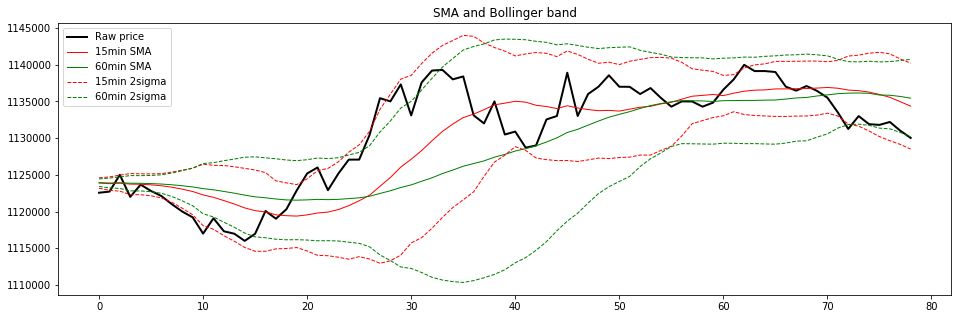

In [ ]:
#  For Last , MA , SD
raws = []
sma1, sma2 = [], []
sgm1, sgm2 = [], []


# the gap of MA
itr1 = 15 # 15mins
itr2 = 30 # 30mins

# Last price list in 60 mins
current_price = api.ticker(produce_code  = "BTC_JPY")['ltp']
ltps2 = current_price*np.ones(itr2)

# draw graph
plt.ion()
fig = plt.figure(figsize=(16,5))
axe = fig.add_subplot(111)


while True:
    # 60s excute
    clear_output(wait = True)
    tick = api.ticker(product_code="BTC_JPY")
    # update last price
    ltps2 = np.hstack((ltps2[1:itr2], tick['ltp']))
    ltps1 = ltps2[itr2 - itr1:itr2]
    # update graph data
    raws = np.append(raws, [ltps1[itr1 -1]])
    sma1 = np.append(sma1, [ltps1.mean()])
    sma2.append(ltps2.mean())
    sgm1 = np.append(sgm1, [ltps1.std()])
    sgm2 = np.append(sgm2, [ltps2.std()])
    # plot
    axe.plot(raws, "black", linewidth=2, label="Raw price")
    axe.plot(sma1, "r", linewidth=1, label="15min SMA")
    axe.plot(sma2, "g", linewidth=1, label="60min SMA")
    axe.plot(sma1+2*sgm1, "r", linewidth=1, linestyle="dashed", label="15min 2sigma")
    axe.plot(sma1-2*sgm1, "r", linewidth=1, linestyle="dashed")
    axe.plot(sma2+2*sgm2, "g", linewidth=1, linestyle="dashed", label="60min 2sigma")
    axe.plot(sma2-2*sgm2, "g", linewidth=1, linestyle="dashed")
    axe.legend(loc='upper left')
    axe.set_title("SMA and Bollinger band")
    display(fig)
    # 次の00秒まで休憩
    time.sleep(57)
    axe.cla()







<p>各関数のはじめに100,000,000を掛けたり割ったりしているのは、注文の最小単位が1 satoshi (=1/100,000,000 BTC)だからです。僕ははじめ、これより小さい単位での注文を送っていたため全く取引が成立しないという問題で数日間悩んでいました。</p>

In [ ]:
# buy
def buy_btc_mkt(amt):
    amt = int(amt*100000000)/10000000
    buy = api.sendchildorder(product_code="BTC_JPY", child_order_type="MARKET", side="BUY", size=amt, minute_to_expire=10, time_in_force="GTC")
    print("BUY ", amt, "BTC")
    pritn(buy)

# sell
def sell_btc_mkr(amt):
    amt = int(amt*100000000)/10000000
    sell = api.sendchildorder(product_code="BTC_JPY", child_order_type="MARKET", side="SELL", size=amt, minute_to_expire=10, time_in_force="GTC")
    print("SELL ", amt, "BTC")
    print(sell)

# lmt_buy
def buy_btc_lmt(amt):
    amt = int(amt*100000000)/10000000
    buy = api.sendchildorder(product_code="BTC_JPY", child_order_type="MARKET", side="BUY", size=amt, minute_to_expire=10, time_in_force="GTC")
    print("BUY ", amt, "BTC")
    print(buy)

# lmt_sell
def sell_btc_lmt(amt, prc):
    amt = int(amt*100000000)/100000000
    sell = api.sendchildorder(product_code="BTC_JPY", child_order_type="LIMIT", price=prc, side="SELL", size=amt, minute_to_expire=10, time_in_force="GTC")
    print("SELL ", amt, "BTC")
    print(sell)

In [ ]:
balance = api.getbalance()
print(balance)

In [ ]:
def compute(x, th1, th2):
    if 0 < x and x < th1:
        out = 0
    elif th1 <= x and x <= th2:
        out = -1/(th1-th2)**2*(x-th2)**2+1
    elif th2 < x:
        out = 1
    else:
        out = 0
    return out  


def main(th1, th2):

    # 移動平均を取る幅[分]
    itr = 20 
    # 最終取引価格と移動平均を一時的に保存する配列を用意
    current_price = api.ticker(product_code = "BTC_JPY")['ltp']
    ltps = current_price*np.ones(itr)
    smas = current_price*np.ones(2)
    # 最小取引額[BTC]
    min_btc = 0.001
    # 資産と時間を格納する配列。あとで確認するときに使える
    jpys = []
    btcs = []
    tms = []
　　　　　　　　# 最終取引価格と移動平均を格納する配列。あとで確認するときに使える
　　　　　　　　raw = []
    smoothed = [] 

    while True:
        # 00秒に稼働
        if datetime.now().strftime('%S')0:2] == '00':
            # 資産を取得し格納
            balance = api.getbalance()
　　　　　　 jpy = balance[0]['available']
            jpys.append(jpy)
            btc = balance[1]['available']
            btcs.append(btc)
　　　　　　 # 時間を文字列で取得し格納
            tick = api.ticker(product_code = "BTC_JPY")
            tm = tick['timestamp']
            tm = str((int(tm[11:13])+9)%24) + tm[13:19]
            tms.append(tm)
            # 最終取引価格と移動平均の更新
            ltps = np.hstack((ltps[1:itr], tick['ltp']))
            smas = np.hstack((smas[1], ltps.mean()))
            # 確認用データの更新
            raw.append(ltps[itr-1])
            smoothed.append(smas[1])

            # 移動平均の分率利率
            r = (smas[1]-smas[0])/smas[0]
            print(tm, r)

            # 利率が正の時はBTC買い
            if r > 0:
                # JPY資産のうちどれだけBTCに変えるかを計算
                amt_jpy = compute(r, th1, th2)*jpy
                amt_btc = amt_jpy/ltps[itr-1]
                # 購入量が最小取引額を超えていれば指値買い
                if amt_btc > min_btc:
                    buy_btc_lmt(amt_btc, ltps[itr-1])

            # 利率が負の時はBTC売り
            if r < 0:
　　　　　　　　　# BTC資産のうちどれだけJPYに変えるかを計算
                amt_btc = compute(-r, th1, th2)*btc
                # 売却量が最小取引額を超えていれば指値売り
                if amt_btc > min_btc:
                    sell_btc_mkt(amt_btc)

            # 次の00秒まで休憩
            time.sleep(57)